If topography is deepened, we need to extend Temp and Salinity Downward.

Also includes a cell to convert to Reference Salinity

In [8]:
from __future__ import division
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import nc_tools
from salishsea_tools import teos_tools
from salishsea_tools import tidetools
%matplotlib inline

In [2]:
# read in old bathymetry
nc_filepath1 = '../../NEMO-forcing/grid/bathy_meter_SalishSea6.nc'
old_bathy = nc.Dataset(nc_filepath1, 'r')
old_depth = old_bathy.variables['Bathymetry']
print (old_depth[416, 335])

13.125


odict_keys(['nav_lat', 'nav_lon', 'deptht', 'deptht_bounds', 'sossheig', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'votemper', 'vosaline', 'buoy_n2', 'mixed_depth'])
[  0.9006294    1.40419185   1.43048728   3.48701859   3.85147262
   5.7931695    6.66281128  10.56869316  12.5706377   12.52894306
  12.50294876  12.4791851   12.43637753   0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.        ]
[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   24.10025597  

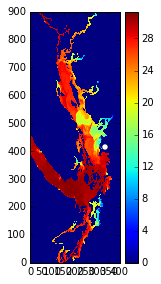

In [3]:
# read in old TS, this also gives the depths of the cells
nc_filepath2 = '/results/SalishSea/nowcast-green/06feb16/SalishSea_1h_20160206_20160206_grid_T.nc'
TS = nc.Dataset(nc_filepath2, 'r')
old_salinity = TS.variables['vosaline'][23]
old_temperature = TS.variables['votemper'][23]
print (TS.variables.keys())
depths = TS.variables['deptht'][:]
lat = TS.variables['nav_lat'][:]
lon = TS.variables['nav_lon'][:]
print (old_salinity[:, 416, 335])
fig, ax = plt.subplots(1,1,figsize=(2,4.5))
mesh = ax.pcolormesh(old_salinity[0])
ax.plot(335, 416, 'ow')
fig.colorbar(mesh, ax=ax)
print (depths)

17.8125
[ 29.37170792  29.72986984  29.72708511  29.72551155  29.72441483
  29.72359657  29.72297287  29.72249603  29.72216225  29.72195244
  29.72189331  29.72199631  29.72236252  29.72326851  29.72401619  29.72472
  29.72613716   0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.        ]
[  0.9006294    1.40419185   1.43048728   3.48701859   3.85147262
   5.7931695    6.66281128  10.56869316  12.5706377   12.52894306
  12.50294876  12.4791851   12.43637753   0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.     

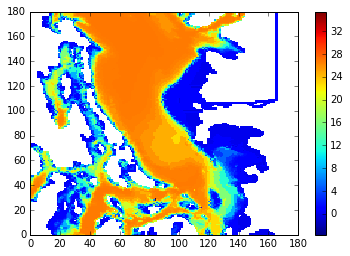

In [4]:
# read in new bathymetry
nc_filepath3 = '../../NEMO-forcing/grid/bathy_downonegrid.nc'
bathy = nc.Dataset(nc_filepath3, 'r')
depth = bathy.variables['Bathymetry'][:]
imin = 320-10
imax = 480+10
jmin = 210-10
jmax = 370+10
plt.pcolormesh(depth[imin:imax,jmin:jmax]-old_depth[imin:imax,jmin:jmax])
plt.colorbar()
print (depth[imin+20, jmin+20])
print (old_salinity[:, imin+20, jmin+20])
print (old_salinity[:, 416, 335])
print (depth[416, 335], old_depth[416, 335])

[   0.            1.0000006     2.00000572    3.00001717    4.00004387
    5.00009727    6.00020409    7.00041676    8.0008297     9.00164223
   10.00322342   11.0063076    12.01231575   13.02401733   14.04680634
   15.09115791   16.17741776   17.34492874   18.66934204   20.2942276
   22.48572922   25.71478271   30.74504852   38.62646484   50.40898132
   66.55968475   86.61148834  109.51442719  134.21859741  159.96032715
  186.26864624  212.87744141  239.64315796  266.4901123   293.37896729
  320.28942871  347.2109375   374.13812256  401.06829834  427.99987793]
[   1.0000006     2.00000572    3.00001717    4.00004387    5.00009727
    6.00020409    7.00041676    8.0008297     9.00164223   10.00322342
   11.0063076    12.01231575   13.02401733   14.04680634   15.09115791
   16.17741776   17.34492874   18.66934204   20.2942276    22.48572922
   25.71478271   30.74504852   38.62646484   50.40898132   66.55968475
   86.61148834  109.51442719  134.21859741  159.96032715  186.26864624
  212.

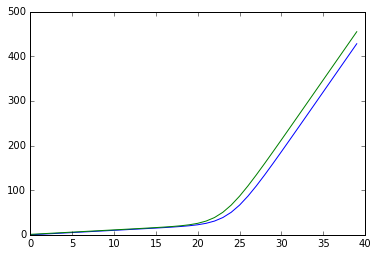

In [5]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]
plt.plot(ceil)
plt.plot(floor)
print (ceil)
print (floor)

In [6]:
S = np.empty_like(old_salinity)
T = np.empty_like(old_temperature)
# for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    print (k)
    for j in range(398):
        for i in range(898):
            if ceil[k] < depth[i,j]:
                if old_salinity[k,i,j] != 0 or old_depth[i,j] == depth[i,j]:
                    S[k,i,j] = old_salinity[k, i, j]
                    T[k,i,j] = old_temperature[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_salinity[k], mask = old_salinity[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array,
                                                             lon_tol=0.01, lat_tol= 0.003)
                    S[k, i, j] = old_salinity[k, X, Y]
                    T[k, i, j] = old_temperature[k, X, Y]
                    if k > 0 and S[k, i, j] < S[k-1, i, j]:
                        S[k, i, j] = S[k-1, i, j]
                        T[k, i, j] = T[k-1, i, j]
            elif k > 0 and depth[i,j] > 0:
                S[k, i, j] = S[k-1, i, j]
                T[k, i, j] = T[k-1, i, j]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [7]:
print ('done')

done


In [9]:
ref_sal = np.zeros_like(S)
ref_sal = teos_tools.psu_teos(S)

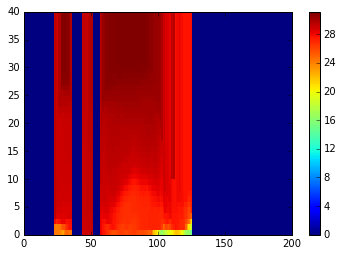

In [10]:
plt.pcolormesh(ref_sal[:, imin+100, jmin-10:jmax+10])
plt.colorbar()

In [11]:
print (lat[20,40])

47.0107


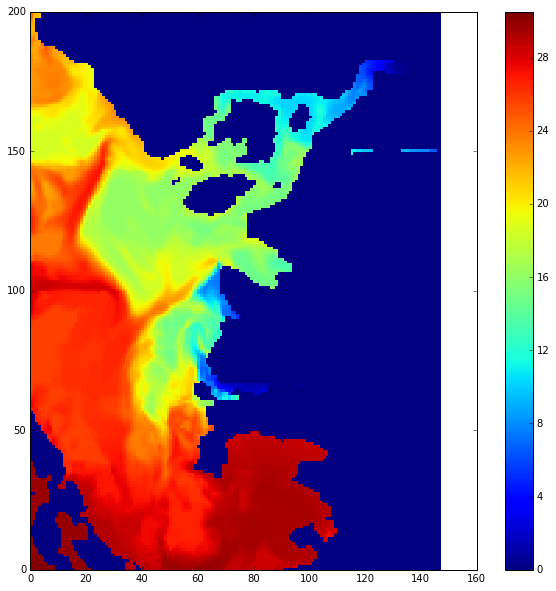

In [12]:
imin=350; imax=550; jmin=250; jmax=-1
id = 0
plt.figure(figsize=(10,10))
plt.pcolormesh(ref_sal[id, imin:imax, jmin:jmax])
plt.colorbar()

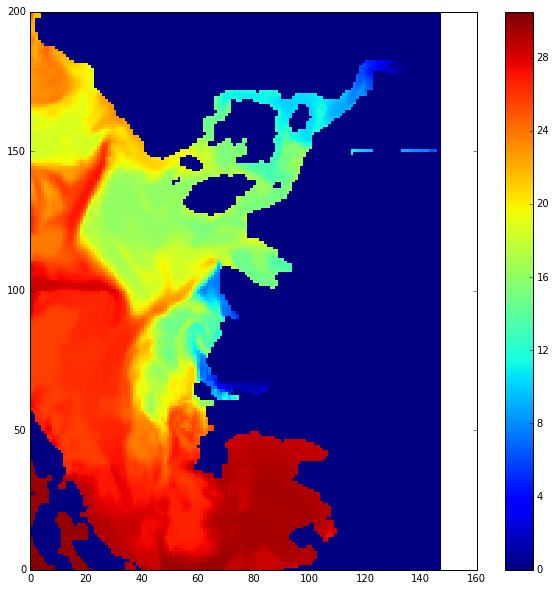

In [13]:
ref_sal[:,imin+50:imin+90,jmin+90:jmin+130] = 0
plt.figure(figsize=(10,10))
plt.pcolormesh(ref_sal[id, imin:imax, jmin:jmax])
plt.colorbar()

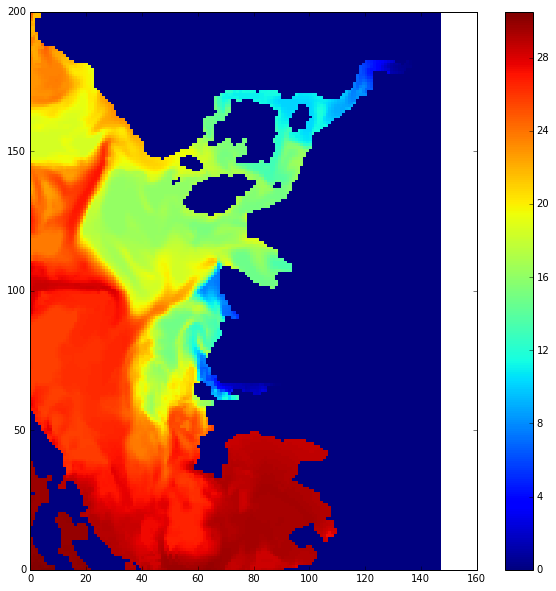

In [14]:
ref_sal[:,imin+50:imin+155,jmin+110:] = 0
plt.figure(figsize=(10,10))
plt.pcolormesh(ref_sal[id, imin:imax, jmin:jmax])
plt.colorbar()

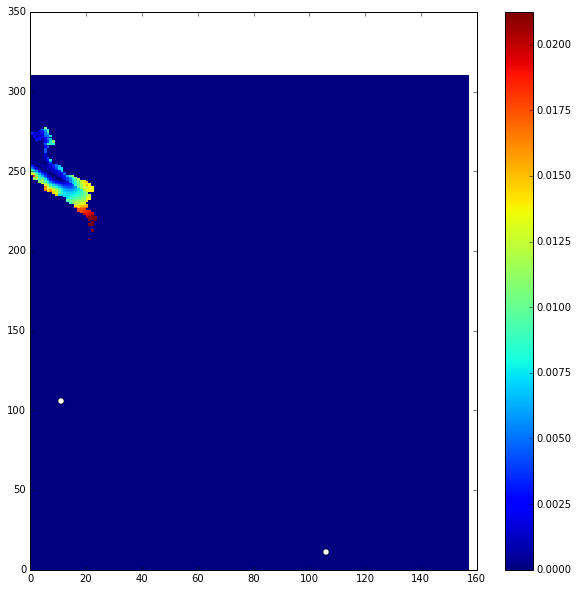

In [15]:
id=39
imin=240; imax=550; jmin=240; jmax=-1
plt.figure(figsize=(10,10))
plt.pcolormesh(ref_sal[id, imin:imax, jmin:jmax]-ref_sal[id-2, imin:imax, jmin:jmax])
plt.colorbar()
plt.plot(251-imin,346-jmin,'wo')
plt.plot(346-imin,251-jmin,'wo')

In [16]:
# build nc file
new_TS = nc.Dataset('TS06jan2016Deep.nc', 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on Jan 6, 2016 23:00 nowcast-green', 
    notebook_name='Find TS for new Bathymetry', 
    nc_filepath='../../../nemo-forcing/initial_strat/TS06jan2016Deep.nc',
    comment='Salinity and Temperature conditions from  Jan 6, 2016 23:00 for Deepen By Grid Thickness')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
nc_tools.show_dimensions(new_TS)
# variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat[:] = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon[:] = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht[:] = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.units = 'irrelevant'
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'g/kg'
vosaline.long_name = 'Reference Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'Deepen by Grid Thickness'
vosaline[0] = ref_sal
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2016-02-07 Created]"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on Jan 6, 2016 23:00 nowcast-green
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Find TS for new Bathymetry.ipynb
references: REQUIRED
history: [2016-02-07 12:12:24] Created netCDF4 zlib=True dataset.
comment: Salinity and Temperature conditions from  Jan 6, 2016 23:00 for Deepen By Grid Thickness
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0



In [17]:
new_TS.close()